## Setup

In [ ]:
!pip install -q mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.7 MB/s eta 0:00:00


## Imports

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm.auto import tqdm
import math
from mediapy import show_image, show_images, show_video
import time
from collections import defaultdict
import einops

/Users/henning/dev/flow_matching/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Accelerator

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: mps


## Num Classes

In [3]:
N_GRAYSCALES = 4

## Prepare dataset

In [10]:
class QuantizeToNGrayscales:

    def __init__(self, num_grayscales: int):
        self.num_grayscales = num_grayscales

    def __call__(self, tensor_image: torch.Tensor) -> torch.Tensor:
        scaled_image = tensor_image * (self.num_grayscales - 1)
        return torch.round(scaled_image).to(torch.int32).squeeze(0)


transform_quantize = T.Compose([
    T.ToTensor(),
    QuantizeToNGrayscales(N_GRAYSCALES)
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True,
    transform=transform_quantize
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True,
    transform=transform_quantize
)

# train_dataset = torchvision.datasets.MNIST(
#     root='./data', train=True, download=True,
#     transform=transforms.ToTensor() # Keep as continuous initially
# )
# test_dataset = torchvision.datasets.MNIST(
#     root='./data', train=False, download=True,
#     transform=transforms.ToTensor()
# )
test_dataset = Subset(test_dataset, range(1_000))

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True
)
print()
print("train - showing original continuous images")
temp_batch = next(iter(train_loader))[0]
show_images(temp_batch.to(torch.uint32)) # This will show continuous images
print(f"Example pixel values from train_loader (continuous): {temp_batch.min()}, {temp_batch.max()}")

print("test - showing original continuous images")
temp_batch_test = next(iter(test_loader))[0]
show_images(temp_batch_test.to(torch.uint32))


train - showing original continuous images


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Example pixel values from train_loader (continuous): 0, 3
test - showing original continuous images


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Flow Matching Model

In [13]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        if self.dim % 2 == 1: # zero pad if dim is odd for a final concat
            pad_tensor = torch.zeros((embeddings.shape[0], 1), device=device)
            embeddings = torch.cat((embeddings.sin(), embeddings.cos(), pad_tensor), dim=-1)
        else:
            embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class MLP(nn.Module):
    def __init__(self, time_embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, t_emb):
        return self.mlp(t_emb)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, num_groups=8):
        super().__init__()

        def get_effective_groups(channels, requested_groups):
            if channels == 0: return 1 # Should not happen with >0 channels
            # Find largest divisor of channels that is <= requested_groups
            # Default to 1 if no other common divisor or too few channels.
            if channels < requested_groups and channels > 0 : # If channels < num_groups, each channel is a group or 1 group
                 return channels # Group per channel is often max useful grouping here.
                                # Or, if channels is small (e.g. 1,2,3) use 1 group.
                                # Let's be robust: use min(channels, requested_groups) then ensure divisibility

            eff_groups = min(channels, requested_groups) if channels > 0 else 1
            while eff_groups > 0 and channels % eff_groups != 0:
                eff_groups -=1
            return eff_groups if eff_groups > 0 else 1 # Fallback to 1 group

        effective_num_groups = get_effective_groups(out_channels, num_groups)


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=effective_num_groups, num_channels=out_channels) if out_channels > 0 else nn.Identity()
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=effective_num_groups, num_channels=out_channels) if out_channels > 0 else nn.Identity()
        self.act2 = nn.SiLU()

        self.time_proj = nn.Linear(time_emb_dim, out_channels) if time_emb_dim is not None and time_emb_dim > 0 else None
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb=None):
        h = self.conv1(x)
        h = self.norm1(h)

        if self.time_proj is not None and t_emb is not None:
            time_cond = self.time_proj(t_emb)
            if time_cond is not None:
                h = h + time_cond[:, :, None, None]

        h = self.act1(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act2(h)
        return h + self.res_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)

    def forward(self, x):
      s = x.shape
      t = einops.rearrange(x, 'b c h w -> b (h w) c')
      t = self.attn(t, t, t)[0]
      return x + einops.rearrange(t, 'b (h w) c -> b c h w', c=s[1], h=s[2])



class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, num_groups_norm=8):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, time_emb_dim, num_groups_norm)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, t_emb=None):
        x_pre_conv = self.pool(x)
        x_post_conv = self.conv(x_pre_conv, t_emb)
        return x_post_conv

class UpBlock(nn.Module):
    def __init__(self, in_channels_prev_up, channels_from_skip, out_channels_conv, time_emb_dim, num_groups_norm):
        super().__init__()
        self.up_conv_transpose = nn.ConvTranspose2d(in_channels_prev_up, in_channels_prev_up // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock( (in_channels_prev_up // 2) + channels_from_skip, out_channels_conv, time_emb_dim, num_groups_norm)

    def forward(self, x_prev_up, x_skip, t_emb):
        x_upsampled = self.up_conv_transpose(x_prev_up)

        if x_upsampled.shape[2:] != x_skip.shape[2:]:
            diffY = x_skip.size(2) - x_upsampled.size(2)
            diffX = x_skip.size(3) - x_upsampled.size(3)
            x_upsampled = F.pad(x_upsampled, [diffX // 2, diffX - diffX // 2,
                                           diffY // 2, diffY - diffY // 2])

        x_cat = torch.cat([x_upsampled, x_skip], dim=1)
        x = self.conv(x_cat, t_emb)
        return x


class UNetFlowMatcherMNIST(nn.Module):
    def __init__(self,
                 num_pixel_classes=1, # Changed from out_channels for discrete output
                 base_channels=32,
                 time_embedding_dim=128,
                 time_mlp_hidden_dim=512,
                 num_groups_norm=8,
                 use_attention_bottleneck=True):
        super().__init__()

        self.num_pixel_classes = num_pixel_classes
        self.embedding = nn.Embedding(num_pixel_classes, base_channels)

        if base_channels <= 0:
            raise ValueError("base_channels must be positive.")
        if time_embedding_dim <= 0 and time_mlp_hidden_dim > 0 :
             time_embedding_dim = 0
             time_mlp_hidden_dim = 0

        self.time_embedding = SinusoidalTimeEmbedding(time_embedding_dim) if time_embedding_dim > 0 else nn.Identity()
        self.time_mlp = MLP(time_embedding_dim, time_mlp_hidden_dim, time_embedding_dim) if time_embedding_dim > 0 else nn.Identity()

        self.conv_in = ConvBlock(base_channels, base_channels, time_embedding_dim, num_groups_norm)
        self.down1 = DownBlock(base_channels, base_channels * 2, time_embedding_dim, num_groups_norm)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_embedding_dim, num_groups_norm)
        self.bottleneck_conv1 = ConvBlock(base_channels * 4, base_channels * 8, time_embedding_dim, num_groups_norm)
        if use_attention_bottleneck:
            self.attention = SelfAttentionBlock(base_channels * 8, num_heads=4)
        else:
            self.attention = nn.Identity()
        self.bottleneck_conv2 = ConvBlock(base_channels * 8, base_channels * 4, time_embedding_dim, num_groups_norm)
        self.up1 = UpBlock(in_channels_prev_up=base_channels * 4, channels_from_skip=base_channels * 2, out_channels_conv=base_channels * 2, time_emb_dim=time_embedding_dim, num_groups_norm=num_groups_norm)
        self.up2 = UpBlock(in_channels_prev_up=base_channels * 2, channels_from_skip=base_channels, out_channels_conv=base_channels, time_emb_dim=time_embedding_dim, num_groups_norm=num_groups_norm)
        self.conv_out = nn.Conv2d(base_channels, self.num_pixel_classes, kernel_size=1)

    def forward(self, x, t):
        x = self.embedding(x)
        x = einops.rearrange(x, "b h w d -> b d h w")
        if isinstance(self.time_embedding, nn.Identity) or t is None:
            t_emb = None
        else:
            t_emb_sin = self.time_embedding(t)
            t_emb = self.time_mlp(t_emb_sin)

        s1_skip = self.conv_in(x, t_emb)
        s2_skip = self.down1(s1_skip, t_emb)
        s3_features = self.down2(s2_skip, t_emb)

        b = self.bottleneck_conv1(s3_features, t_emb)
        b = self.attention(b)
        b = self.bottleneck_conv2(b, t_emb)

        u1 = self.up1(b, s2_skip, t_emb)
        u2 = self.up2(u1, s1_skip, t_emb)

        out_logits = self.conv_out(u2)
        return out_logits

## Flow Matching Loss and sampling

In [14]:
def flow_matching_loss(model, batch, K=N_GRAYSCALES):
    x0_discrete = batch[0].to(next(model.parameters()).device)
    batch_size, H, W = x0_discrete.shape
    t_scalar = torch.rand((batch_size,), device=x0_discrete.device)
    t_broadcast = t_scalar.view(batch_size, 1, 1)
    noise_discrete = torch.randint(0, K, size=(batch_size, H, W), device=x0_discrete.device, dtype=torch.long)
    mask = torch.rand((batch_size, H, W), device=x0_discrete.device) < t_broadcast
    x_t_discrete = torch.where(mask, noise_discrete, x0_discrete)

    logits_pred_x0 = model(x_t_discrete, t_scalar)

    x0_target_for_loss = x0_discrete.squeeze(1)
    loss = F.cross_entropy(logits_pred_x0, x0_target_for_loss.to(torch.int64))
    return {"loss": loss}


@torch.no_grad()
def sample_batch(model, initial_noise_discrete, num_steps=10, K=N_GRAYSCALES):
    model.eval()
    device = next(model.parameters()).device
    x_est_x0_discrete = initial_noise_discrete.clone().to(device)
    fixed_x1_sample_discrete = torch.randint(0, K, size=initial_noise_discrete.shape, device=device, dtype=torch.long)

    for i in range(num_steps):
        t_model_scalar = (num_steps - i) / num_steps
        t_for_model_nn = torch.full((x_est_x0_discrete.shape[0],), t_model_scalar, device=device, dtype=torch.float)
        mask_prob = t_model_scalar
        mask = torch.rand_like(x_est_x0_discrete, dtype=torch.float) < mask_prob
        x_t_formed_discrete = torch.where(mask, fixed_x1_sample_discrete, x_est_x0_discrete)
        logits_x0_pred = model(x_t_formed_discrete, t_for_model_nn)
        x_est_x0_discrete = torch.argmax(logits_x0_pred, dim=1, keepdim=False)

    # final_image_float = x_est_x0_discrete.squeeze(1).float() / (K - 1.0)
    return x_est_x0_discrete.squeeze(1)

## Trainer

In [ ]:
class TrainLossLogger:
  def __init__(self, log_every_sec=10.0) -> None:
    self.running = defaultdict(list)
    self.log_every_sec = log_every_sec
    self.last_log = time.time()

  def log(self, data) -> None:
    for k, v in data.items():
      self.running[k].append(v)
    if self.last_log + self.log_every_sec < time.time():
      self.last_log = time.time()
      print("mean train:", {k: float(np.array(v).mean()) for k, v in self.running.items()})
      self.running = defaultdict(list)


class Trainer:
    def __init__(self, *, model, train_loader, test_loader, loss_fn, extra_eval_fn=None, num_epochs=5, batch_size=32):
        self.model = model
        self.device = next(model.parameters()).device
        self.loss_fn = loss_fn
        self.extra_eval_fn = extra_eval_fn
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        loss_logger = TrainLossLogger()

        for epoch in range(self.num_epochs):
            print(f"epoch={epoch} test {self.eval()}")
            if self.extra_eval_fn:
                self.extra_eval_fn(self.model)

            self.model.train()
            prog_bar = tqdm(enumerate(self.train_loader), desc=f"Epoch {epoch + 1}/{self.num_epochs}", total=len(self.train_loader), unit=" batches")
            for i, batch in prog_bar:
                optimizer.zero_grad()
                loss_dict = self.loss_fn(self.model, batch)
                loss = loss_dict["loss"]
                loss.backward()
                optimizer.step()
                log_items = {k: v.item() for k, v in loss_dict.items()}
                loss_logger.log(log_items)
                prog_bar.set_postfix(log_items)

        print(f"epoch={epoch} test {self.eval()}") # Final eval after last epoch
        if self.extra_eval_fn:
            self.extra_eval_fn(self.model)

    @torch.no_grad()
    def eval(self) -> float:
        torch.manual_seed(17)

        self.model.eval()
        total_loss_vals = defaultdict(list)
        for batch in self.test_loader:
            loss_dict = self.loss_fn(self.model, batch)
            for k, v in loss_dict.items():
              total_loss_vals[k].append(v.item())

        torch.random.seed()
        return {k: float(np.array(v).mean()) for k, v in total_loss_vals.items()}

## Train the Flow matching model

In [ ]:
fm_model = UNetFlowMatcherMNIST(num_pixel_classes=N_GRAYSCALES, base_channels=32)
fm_model.to(device)

def sample_and_viz(model_to_eval):
  torch.manual_seed(1)
  initial_noise = torch.randint(0, N_GRAYSCALES, (20, 28, 28),
                                dtype=torch.long, device=device)
  imgs = sample_batch(model_to_eval, initial_noise, num_steps=20, K=N_GRAYSCALES)
  show_images(imgs.cpu().to(torch.uint8))
  print(f"Generated sample images (min/max): {imgs.min()}/{imgs.max()}")
  torch.random.seed()

trainer_fm = Trainer(model=fm_model,
                  train_loader=train_loader,
                  test_loader=test_loader,
                  loss_fn=flow_matching_loss,
                  extra_eval_fn=sample_and_viz,
                  num_epochs=5)
trainer_fm.train()


epoch=0 test {'loss': 1.3219246789813042}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 1/5:   0%|          | 2/1875 [00:08<1:51:11,  3.56s/ batches, loss=0.86]

mean train: {'loss': 1.3282442092895508}


Epoch 1/5:   4%|▎         | 69/1875 [00:18<05:32,  5.44 batches/s, loss=0.275] 

mean train: {'loss': 0.3253377571479598}


Epoch 1/5:   6%|▋         | 121/1875 [00:28<06:09,  4.75 batches/s, loss=0.238]

mean train: {'loss': 0.25521188945724416}


Epoch 1/5:   9%|▉         | 166/1875 [00:39<05:12,  5.48 batches/s, loss=0.284]

mean train: {'loss': 0.23759122292200724}


Epoch 1/5:  11%|█▏        | 211/1875 [00:48<07:19,  3.78 batches/s, loss=0.239]

mean train: {'loss': 0.23614284882079}


Epoch 1/5:  14%|█▍        | 265/1875 [00:59<05:22,  4.99 batches/s, loss=0.228]

mean train: {'loss': 0.2329147460888017}


Epoch 1/5:  17%|█▋        | 310/1875 [01:09<06:48,  3.83 batches/s, loss=0.229]

mean train: {'loss': 0.22081863491431528}


Epoch 1/5:  18%|█▊        | 346/1875 [01:19<06:55,  3.68 batches/s, loss=0.217]

mean train: {'loss': 0.22221853708227476}


Epoch 1/5:  21%|██▏       | 402/1875 [01:29<04:14,  5.79 batches/s, loss=0.239]

mean train: {'loss': 0.2165218025445938}


Epoch 1/5:  24%|██▍       | 454/1875 [01:39<04:13,  5.60 batches/s, loss=0.146]

mean train: {'loss': 0.2135326567123521}


Epoch 1/5:  26%|██▌       | 491/1875 [01:49<04:44,  4.87 batches/s, loss=0.216]

mean train: {'loss': 0.21667006156510776}


Epoch 1/5:  28%|██▊       | 534/1875 [01:59<04:36,  4.85 batches/s, loss=0.216]

mean train: {'loss': 0.21182000983593074}


Epoch 1/5:  31%|███       | 583/1875 [02:09<03:38,  5.92 batches/s, loss=0.23] 

mean train: {'loss': 0.21356557279217}


Epoch 1/5:  34%|███▍      | 641/1875 [02:20<03:29,  5.88 batches/s, loss=0.174]

mean train: {'loss': 0.2124871889065052}


Epoch 1/5:  37%|███▋      | 699/1875 [02:30<03:21,  5.84 batches/s, loss=0.194]

mean train: {'loss': 0.2070866026755037}


Epoch 1/5:  40%|███▉      | 742/1875 [02:40<04:51,  3.88 batches/s, loss=0.216]

mean train: {'loss': 0.2068325514820489}


Epoch 1/5:  42%|████▏     | 793/1875 [02:50<03:05,  5.82 batches/s, loss=0.196]

mean train: {'loss': 0.21008923083543776}


Epoch 1/5:  45%|████▌     | 846/1875 [03:00<02:56,  5.84 batches/s, loss=0.24] 

mean train: {'loss': 0.20782691915080231}


Epoch 1/5:  48%|████▊     | 892/1875 [03:10<03:06,  5.26 batches/s, loss=0.203]

mean train: {'loss': 0.21191768769336783}


Epoch 1/5:  50%|█████     | 945/1875 [03:20<02:47,  5.56 batches/s, loss=0.208]

mean train: {'loss': 0.20744398995390478}


Epoch 1/5:  53%|█████▎    | 1001/1875 [03:30<02:37,  5.54 batches/s, loss=0.168]

mean train: {'loss': 0.2012663653918675}


Epoch 1/5:  56%|█████▌    | 1052/1875 [03:40<02:27,  5.58 batches/s, loss=0.184]

mean train: {'loss': 0.20330758977170085}


Epoch 1/5:  59%|█████▊    | 1101/1875 [03:51<02:39,  4.85 batches/s, loss=0.224]

mean train: {'loss': 0.20291564476733304}


Epoch 1/5:  61%|██████    | 1144/1875 [04:01<02:31,  4.84 batches/s, loss=0.193]

mean train: {'loss': 0.20754608546578607}


Epoch 1/5:  64%|██████▎   | 1193/1875 [04:11<02:29,  4.56 batches/s, loss=0.201]

mean train: {'loss': 0.2023658281078144}


Epoch 1/5:  66%|██████▌   | 1242/1875 [04:21<01:50,  5.75 batches/s, loss=0.201]

mean train: {'loss': 0.1961049686889259}


Epoch 1/5:  69%|██████▉   | 1292/1875 [04:31<01:43,  5.66 batches/s, loss=0.197]

mean train: {'loss': 0.2011588415503502}


Epoch 1/5:  72%|███████▏  | 1349/1875 [04:41<01:32,  5.67 batches/s, loss=0.195]

mean train: {'loss': 0.20343317601241565}


Epoch 1/5:  75%|███████▍  | 1398/1875 [04:51<01:38,  4.86 batches/s, loss=0.188]

mean train: {'loss': 0.2048388172169121}


Epoch 1/5:  77%|███████▋  | 1452/1875 [05:01<01:15,  5.58 batches/s, loss=0.177]

mean train: {'loss': 0.2023229369962657}


Epoch 1/5:  80%|████████  | 1506/1875 [05:11<01:03,  5.82 batches/s, loss=0.191]

mean train: {'loss': 0.20306087082082575}


Epoch 1/5:  83%|████████▎ | 1554/1875 [05:21<01:20,  4.00 batches/s, loss=0.214]

mean train: {'loss': 0.20447000163666745}


Epoch 1/5:  85%|████████▍ | 1593/1875 [05:31<01:06,  4.23 batches/s, loss=0.144]

mean train: {'loss': 0.20286257676780223}


Epoch 1/5:  87%|████████▋ | 1635/1875 [05:41<00:44,  5.43 batches/s, loss=0.212]

mean train: {'loss': 0.20134804088894914}


Epoch 1/5:  90%|████████▉ | 1684/1875 [05:51<00:34,  5.52 batches/s, loss=0.181]

mean train: {'loss': 0.20097084556307113}


Epoch 1/5:  93%|█████████▎| 1739/1875 [06:01<00:24,  5.47 batches/s, loss=0.212]

mean train: {'loss': 0.21300180391831833}


Epoch 1/5:  96%|█████████▌| 1792/1875 [06:12<00:14,  5.70 batches/s, loss=0.171]

mean train: {'loss': 0.19807534875734797}


Epoch 1/5:  98%|█████████▊| 1837/1875 [06:22<00:10,  3.55 batches/s, loss=0.211]

mean train: {'loss': 0.1984254154894087}


Epoch 1/5: 100%|██████████| 1875/1875 [06:29<00:00,  4.81 batches/s, loss=0.187]


epoch=1 test {'loss': 0.20092172361910343}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 2/5:   0%|          | 3/1875 [00:01<22:38,  1.38 batches/s, loss=0.216]

mean train: {'loss': 0.19798813795759565}


Epoch 2/5:   3%|▎         | 47/1875 [00:12<05:20,  5.70 batches/s, loss=0.201]

mean train: {'loss': 0.19670751864133879}


Epoch 2/5:   5%|▍         | 87/1875 [00:22<05:35,  5.33 batches/s, loss=0.174]

mean train: {'loss': 0.19984702616930008}


Epoch 2/5:   7%|▋         | 131/1875 [00:32<09:22,  3.10 batches/s, loss=0.224]

mean train: {'loss': 0.20361750369722192}


Epoch 2/5:   9%|▉         | 177/1875 [00:42<06:27,  4.38 batches/s, loss=0.174]

mean train: {'loss': 0.19984401438547217}


Epoch 2/5:  12%|█▏        | 229/1875 [00:52<05:03,  5.42 batches/s, loss=0.193]

mean train: {'loss': 0.19643723764098608}


Epoch 2/5:  15%|█▍        | 278/1875 [01:02<04:40,  5.69 batches/s, loss=0.188]

mean train: {'loss': 0.19541994497484091}


Epoch 2/5:  18%|█▊        | 329/1875 [01:12<04:48,  5.35 batches/s, loss=0.204]

mean train: {'loss': 0.18655949286543405}


Epoch 2/5:  20%|██        | 379/1875 [01:22<05:00,  4.98 batches/s, loss=0.169]

mean train: {'loss': 0.19512781143188476}


Epoch 2/5:  23%|██▎       | 425/1875 [01:32<04:54,  4.92 batches/s, loss=0.191]

mean train: {'loss': 0.2003198931614558}


Epoch 2/5:  24%|██▍       | 457/1875 [01:42<14:56,  1.58 batches/s, loss=0.149]

mean train: {'loss': 0.19311286509037018}


Epoch 2/5:  27%|██▋       | 502/1875 [01:52<05:14,  4.36 batches/s, loss=0.204]

mean train: {'loss': 0.19337768886577}


Epoch 2/5:  29%|██▉       | 544/1875 [02:02<05:12,  4.26 batches/s, loss=0.211]

mean train: {'loss': 0.19669521954797564}


Epoch 2/5:  32%|███▏      | 591/1875 [02:14<14:52,  1.44 batches/s, loss=0.162]

mean train: {'loss': 0.19644993046919504}


Epoch 2/5:  33%|███▎      | 621/1875 [02:24<05:34,  3.75 batches/s, loss=0.184]

mean train: {'loss': 0.1951100574485187}


Epoch 2/5:  35%|███▌      | 664/1875 [02:34<04:54,  4.12 batches/s, loss=0.248]

mean train: {'loss': 0.1927153200588443}


Epoch 2/5:  38%|███▊      | 718/1875 [02:44<03:27,  5.57 batches/s, loss=0.209]

mean train: {'loss': 0.19648493235965944}


Epoch 2/5:  41%|████      | 766/1875 [02:54<05:00,  3.69 batches/s, loss=0.174]

mean train: {'loss': 0.1843463802824215}


Epoch 2/5:  44%|████▎     | 819/1875 [03:05<04:17,  4.11 batches/s, loss=0.2]  

mean train: {'loss': 0.19033542219197974}


Epoch 2/5:  46%|████▌     | 867/1875 [03:15<03:12,  5.25 batches/s, loss=0.255]

mean train: {'loss': 0.18590172110719883}


Epoch 2/5:  48%|████▊     | 904/1875 [03:25<03:26,  4.70 batches/s, loss=0.166]

mean train: {'loss': 0.19778402109403867}


Epoch 2/5:  51%|█████     | 951/1875 [03:35<02:58,  5.17 batches/s, loss=0.201]

mean train: {'loss': 0.1909818281518652}


Epoch 2/5:  53%|█████▎    | 997/1875 [03:45<02:49,  5.19 batches/s, loss=0.195]

mean train: {'loss': 0.19917264775089596}


Epoch 2/5:  56%|█████▌    | 1042/1875 [03:55<02:21,  5.90 batches/s, loss=0.25] 

mean train: {'loss': 0.19195286002424028}


Epoch 2/5:  58%|█████▊    | 1091/1875 [04:05<02:16,  5.73 batches/s, loss=0.233]

mean train: {'loss': 0.19291288420557975}


Epoch 2/5:  60%|██████    | 1133/1875 [04:15<02:15,  5.46 batches/s, loss=0.173]

mean train: {'loss': 0.19013770102035432}


Epoch 2/5:  63%|██████▎   | 1185/1875 [04:25<02:24,  4.77 batches/s, loss=0.209]

mean train: {'loss': 0.18522356991090028}


Epoch 2/5:  66%|██████▌   | 1234/1875 [04:35<01:52,  5.69 batches/s, loss=0.205]

mean train: {'loss': 0.19749833554029464}


Epoch 2/5:  69%|██████▊   | 1286/1875 [04:45<01:48,  5.45 batches/s, loss=0.174]

mean train: {'loss': 0.19758842856276268}


Epoch 2/5:  71%|███████▏  | 1338/1875 [04:55<01:36,  5.58 batches/s, loss=0.169]

mean train: {'loss': 0.18589760784832937}


Epoch 2/5:  74%|███████▍  | 1388/1875 [05:06<02:49,  2.88 batches/s, loss=0.208]

mean train: {'loss': 0.19812945336103438}


Epoch 2/5:  76%|███████▌  | 1429/1875 [05:16<02:01,  3.68 batches/s, loss=0.211]

mean train: {'loss': 0.19492229019723287}


Epoch 2/5:  78%|███████▊  | 1471/1875 [05:26<01:45,  3.85 batches/s, loss=0.169]

mean train: {'loss': 0.18422428429836318}


Epoch 2/5:  81%|████████  | 1522/1875 [05:36<01:09,  5.09 batches/s, loss=0.24] 

mean train: {'loss': 0.19383966505527497}


Epoch 2/5:  84%|████████▍ | 1573/1875 [05:46<00:56,  5.33 batches/s, loss=0.159]

mean train: {'loss': 0.1941068245499742}


Epoch 2/5:  87%|████████▋ | 1628/1875 [05:56<00:45,  5.47 batches/s, loss=0.18] 

mean train: {'loss': 0.1853951338146414}


Epoch 2/5:  90%|████████▉ | 1682/1875 [06:06<00:34,  5.58 batches/s, loss=0.132]

mean train: {'loss': 0.1900291216542136}


Epoch 2/5:  92%|█████████▏| 1733/1875 [06:17<00:27,  5.11 batches/s, loss=0.152]

mean train: {'loss': 0.19221806613837972}


Epoch 2/5:  95%|█████████▌| 1786/1875 [06:27<00:16,  5.38 batches/s, loss=0.208]

mean train: {'loss': 0.1960380735262385}


Epoch 2/5:  98%|█████████▊| 1841/1875 [06:37<00:06,  4.92 batches/s, loss=0.2]  

mean train: {'loss': 0.198878844759681}


Epoch 2/5: 100%|██████████| 1875/1875 [06:43<00:00,  4.65 batches/s, loss=0.185]


epoch=2 test {'loss': 0.19198512006551027}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 3/5:   1%|          | 12/1875 [00:02<05:18,  5.85 batches/s, loss=0.185]

mean train: {'loss': 0.20327427238225937}


Epoch 3/5:   4%|▎         | 67/1875 [00:12<05:31,  5.45 batches/s, loss=0.207]

mean train: {'loss': 0.19214307367801667}


Epoch 3/5:   6%|▌         | 117/1875 [00:22<05:16,  5.56 batches/s, loss=0.219]

mean train: {'loss': 0.19710684150457383}


Epoch 3/5:   9%|▊         | 164/1875 [00:32<05:01,  5.68 batches/s, loss=0.172]

mean train: {'loss': 0.19824369156614263}


Epoch 3/5:  11%|█         | 206/1875 [00:42<05:54,  4.71 batches/s, loss=0.24] 

mean train: {'loss': 0.18472657547820182}


Epoch 3/5:  14%|█▍        | 258/1875 [00:52<04:47,  5.63 batches/s, loss=0.187]

mean train: {'loss': 0.19920225928609187}


Epoch 3/5:  17%|█▋        | 310/1875 [01:02<05:29,  4.76 batches/s, loss=0.219]

mean train: {'loss': 0.1937361150406874}


Epoch 3/5:  19%|█▉        | 357/1875 [01:13<12:55,  1.96 batches/s, loss=0.209]

mean train: {'loss': 0.20025953215857348}


Epoch 3/5:  21%|██▏       | 399/1875 [01:23<05:17,  4.64 batches/s, loss=0.192]

mean train: {'loss': 0.18802485923941542}


Epoch 3/5:  23%|██▎       | 437/1875 [01:33<05:04,  4.72 batches/s, loss=0.196]

mean train: {'loss': 0.19820027167980486}


Epoch 3/5:  26%|██▌       | 485/1875 [01:43<04:31,  5.13 batches/s, loss=0.179]

mean train: {'loss': 0.18299218378168472}


Epoch 3/5:  28%|██▊       | 531/1875 [01:53<04:01,  5.56 batches/s, loss=0.206]

mean train: {'loss': 0.1876213535990404}


Epoch 3/5:  30%|███       | 569/1875 [02:03<05:27,  3.99 batches/s, loss=0.158]

mean train: {'loss': 0.18814991682003707}


Epoch 3/5:  31%|███       | 579/1875 [02:27<2:21:01,  6.53s/ batches, loss=0.189]

mean train: {'loss': 0.19523584097623825}


Epoch 3/5:  33%|███▎      | 613/1875 [02:37<04:18,  4.89 batches/s, loss=0.212]  

mean train: {'loss': 0.1947691493174609}


Epoch 3/5:  34%|███▎      | 631/1875 [11:32<55:00:30, 159.19s/ batches, loss=0.129]

mean train: {'loss': 0.18900328460666868}


Epoch 3/5:  36%|███▌      | 674/1875 [11:42<04:27,  4.48 batches/s, loss=0.184]    

mean train: {'loss': 0.18023993664009627}


Epoch 3/5:  39%|███▉      | 732/1875 [11:53<03:14,  5.88 batches/s, loss=0.235]

mean train: {'loss': 0.18382266582104198}


Epoch 3/5:  41%|████      | 767/1875 [12:03<04:54,  3.76 batches/s, loss=0.215] 

mean train: {'loss': 0.18469815509659904}


Epoch 3/5:  41%|████▏     | 774/1875 [16:33<24:39:27, 80.62s/ batches, loss=0.24]

mean train: {'loss': 0.19930985569953918}


Epoch 3/5:  43%|████▎     | 815/1875 [16:44<03:34,  4.93 batches/s, loss=0.225]   

mean train: {'loss': 0.1922056835144758}


Epoch 3/5:  44%|████▍     | 832/1875 [25:38<32:21:59, 111.72s/ batches, loss=0.198]

mean train: {'loss': 0.19571474808103898}


Epoch 3/5:  46%|████▌     | 859/1875 [25:49<13:36,  1.24 batches/s, loss=0.19]     

mean train: {'loss': 0.19289237314036914}


Epoch 3/5:  48%|████▊     | 897/1875 [34:45<42:54:04, 157.92s/ batches, loss=0.211]

mean train: {'loss': 0.18866844749764392}


Epoch 3/5:  49%|████▉     | 928/1875 [34:55<03:24,  4.63 batches/s, loss=0.203]    

mean train: {'loss': 0.1980648934841156}


Epoch 3/5:  50%|████▉     | 937/1875 [43:52<29:18:49, 112.50s/ batches, loss=0.216]

mean train: {'loss': 0.1831562425941229}


Epoch 3/5:  52%|█████▏    | 972/1875 [44:02<02:51,  5.28 batches/s, loss=0.184]    

mean train: {'loss': 0.19205087508474078}


Epoch 3/5:  52%|█████▏    | 983/1875 [52:58<39:40:09, 160.10s/ batches, loss=0.247]

mean train: {'loss': 0.19568684697151184}


Epoch 3/5:  54%|█████▍    | 1016/1875 [53:08<03:18,  4.34 batches/s, loss=0.205]   

mean train: {'loss': 0.18190902607007461}


Epoch 3/5:  57%|█████▋    | 1063/1875 [53:18<03:31,  3.84 batches/s, loss=0.172]

mean train: {'loss': 0.1880631852657237}


Epoch 3/5:  60%|█████▉    | 1117/1875 [53:28<02:40,  4.73 batches/s, loss=0.203]

mean train: {'loss': 0.19047670176735632}


Epoch 3/5:  60%|█████▉    | 1123/1875 [1:02:06<32:24:46, 155.17s/ batches, loss=0.182]

mean train: {'loss': 0.18566269675890604}


Epoch 3/5:  62%|██████▏   | 1168/1875 [1:02:16<02:04,  5.67 batches/s, loss=0.203]    

mean train: {'loss': 0.18841241672635078}


Epoch 3/5:  63%|██████▎   | 1178/1875 [1:11:12<31:00:39, 160.17s/ batches, loss=0.194]

mean train: {'loss': 0.1960154961455952}


Epoch 3/5:  65%|██████▌   | 1224/1875 [1:11:22<01:57,  5.53 batches/s, loss=0.149]    

mean train: {'loss': 0.184026903907458}


Epoch 3/5:  68%|██████▊   | 1268/1875 [1:11:32<01:48,  5.60 batches/s, loss=0.151]

mean train: {'loss': 0.1952297146121661}


Epoch 3/5:  68%|██████▊   | 1276/1875 [1:20:18<18:21:06, 110.29s/ batches, loss=0.162]

mean train: {'loss': 0.18690708066735948}


Epoch 3/5:  70%|███████   | 1318/1875 [1:20:28<01:35,  5.81 batches/s, loss=0.168]    

mean train: {'loss': 0.18636093643449603}


Epoch 3/5:  71%|███████   | 1332/1875 [1:29:24<16:55:11, 112.18s/ batches, loss=0.199]

mean train: {'loss': 0.1971178501844406}


Epoch 3/5:  73%|███████▎  | 1368/1875 [1:29:34<02:28,  3.42 batches/s, loss=0.205]    

mean train: {'loss': 0.18877507061571688}


Epoch 3/5:  73%|███████▎  | 1371/1875 [1:38:29<22:28:35, 160.55s/ batches, loss=0.153]

mean train: {'loss': 0.1728713313738505}


Epoch 3/5:  75%|███████▌  | 1409/1875 [1:38:39<02:17,  3.39 batches/s, loss=0.201]    

mean train: {'loss': 0.18696415659628415}


Epoch 3/5:  76%|███████▌  | 1419/1875 [1:46:34<17:58:26, 141.90s/ batches, loss=0.196]

mean train: {'loss': 0.18339382559061052}


Epoch 3/5:  77%|███████▋  | 1453/1875 [1:46:44<01:34,  4.48 batches/s, loss=0.189]    

mean train: {'loss': 0.19407855105750701}


Epoch 3/5:  80%|███████▉  | 1495/1875 [1:46:54<01:42,  3.69 batches/s, loss=0.176]

mean train: {'loss': 0.19186390475148246}


Epoch 3/5:  82%|████████▏ | 1544/1875 [1:47:04<00:55,  6.00 batches/s, loss=0.222]

mean train: {'loss': 0.1898956916605433}


Epoch 3/5:  83%|████████▎ | 1558/1875 [1:55:41<9:31:24, 108.15s/ batches, loss=0.173] 

mean train: {'loss': 0.1843669010060174}


Epoch 3/5:  85%|████████▍ | 1586/1875 [1:55:51<01:07,  4.28 batches/s, loss=0.219]   

mean train: {'loss': 0.18983708578964759}


Epoch 3/5:  87%|████████▋ | 1633/1875 [1:56:01<00:42,  5.63 batches/s, loss=0.173]

mean train: {'loss': 0.1902571688203708}


Epoch 3/5:  88%|████████▊ | 1645/1875 [2:03:00<7:58:44, 124.89s/ batches, loss=0.172]

mean train: {'loss': 0.18377303790587646}


Epoch 3/5:  90%|████████▉ | 1685/1875 [2:03:10<00:34,  5.47 batches/s, loss=0.185]   

mean train: {'loss': 0.18476436344476846}


Epoch 3/5:  92%|█████████▏| 1733/1875 [2:03:20<00:34,  4.10 batches/s, loss=0.199]

mean train: {'loss': 0.18359704408794641}


Epoch 3/5:  95%|█████████▌| 1787/1875 [2:03:30<00:19,  4.42 batches/s, loss=0.176]

mean train: {'loss': 0.19593848977927808}


Epoch 3/5:  96%|█████████▌| 1792/1875 [2:12:07<3:34:08, 154.80s/ batches, loss=0.208]

mean train: {'loss': 0.1813132663567861}


Epoch 3/5:  98%|█████████▊| 1830/1875 [2:12:17<00:15,  2.84 batches/s, loss=0.185]   

mean train: {'loss': 0.18604162657583082}


Epoch 3/5:  98%|█████████▊| 1839/1875 [2:19:45<1:20:22, 133.96s/ batches, loss=0.194]

mean train: {'loss': 0.19305520504713058}


Epoch 3/5:  99%|█████████▉| 1852/1875 [2:19:55<00:37,  1.65s/ batches, loss=0.157]   

mean train: {'loss': 0.20175565779209137}


Epoch 3/5: 100%|██████████| 1875/1875 [2:20:01<00:00,  4.48s/ batches, loss=0.2]  


epoch=3 test {'loss': 0.18951482325792313}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 4/5:   1%|          | 10/1875 [00:02<06:13,  4.99 batches/s, loss=0.171]

mean train: {'loss': 0.19156051223928278}


Epoch 4/5:   2%|▏         | 44/1875 [00:12<08:44,  3.49 batches/s, loss=0.165]

mean train: {'loss': 0.17998982401508273}


Epoch 4/5:   4%|▍         | 75/1875 [00:22<09:27,  3.17 batches/s, loss=0.176]

mean train: {'loss': 0.18974381685256958}


Epoch 4/5:   6%|▌         | 111/1875 [00:32<05:32,  5.30 batches/s, loss=0.192]

mean train: {'loss': 0.18388812823428047}


Epoch 4/5:   8%|▊         | 157/1875 [00:43<04:50,  5.91 batches/s, loss=0.159]

mean train: {'loss': 0.1879460159275267}


Epoch 4/5:  11%|█         | 209/1875 [00:53<04:44,  5.85 batches/s, loss=0.214]

mean train: {'loss': 0.18364025050630936}


Epoch 4/5:  14%|█▍        | 266/1875 [01:03<04:44,  5.66 batches/s, loss=0.178]

mean train: {'loss': 0.19198113915167356}


Epoch 4/5:  17%|█▋        | 324/1875 [01:13<04:15,  6.08 batches/s, loss=0.213]

mean train: {'loss': 0.18635202301987286}


Epoch 4/5:  20%|██        | 381/1875 [01:23<04:24,  5.64 batches/s, loss=0.173]

mean train: {'loss': 0.1880358698075278}


Epoch 4/5:  23%|██▎       | 433/1875 [01:33<04:13,  5.70 batches/s, loss=0.169]

mean train: {'loss': 0.18551508824412638}


Epoch 4/5:  25%|██▌       | 477/1875 [01:44<06:06,  3.82 batches/s, loss=0.213]

mean train: {'loss': 0.18749792230400172}


Epoch 4/5:  28%|██▊       | 517/1875 [01:54<04:15,  5.32 batches/s, loss=0.198]

mean train: {'loss': 0.18490683920681478}


Epoch 4/5:  30%|███       | 570/1875 [02:04<03:57,  5.49 batches/s, loss=0.181]

mean train: {'loss': 0.19760402671571048}


Epoch 4/5:  33%|███▎      | 622/1875 [02:14<03:40,  5.68 batches/s, loss=0.177]

mean train: {'loss': 0.18412362999067858}


Epoch 4/5:  36%|███▌      | 672/1875 [02:24<03:58,  5.04 batches/s, loss=0.154]

mean train: {'loss': 0.18426820144057274}


Epoch 4/5:  39%|███▉      | 728/1875 [02:34<03:21,  5.69 batches/s, loss=0.194]

mean train: {'loss': 0.1840976532548666}


Epoch 4/5:  42%|████▏     | 784/1875 [02:44<03:02,  5.97 batches/s, loss=0.215]

mean train: {'loss': 0.19029572632695949}


Epoch 4/5:  45%|████▍     | 835/1875 [02:54<03:01,  5.74 batches/s, loss=0.211]

mean train: {'loss': 0.18527619248511745}


Epoch 4/5:  48%|████▊     | 892/1875 [03:04<02:56,  5.58 batches/s, loss=0.214]

mean train: {'loss': 0.1884890151651282}


Epoch 4/5:  50%|█████     | 946/1875 [03:14<03:09,  4.91 batches/s, loss=0.194]

mean train: {'loss': 0.1853028922169297}


Epoch 4/5:  53%|█████▎    | 999/1875 [03:24<03:07,  4.66 batches/s, loss=0.148]

mean train: {'loss': 0.19572175111410753}


Epoch 4/5:  56%|█████▌    | 1045/1875 [03:34<02:48,  4.93 batches/s, loss=0.223] 

mean train: {'loss': 0.18775324840494928}


Epoch 4/5:  58%|█████▊    | 1089/1875 [03:44<02:19,  5.65 batches/s, loss=0.211]

mean train: {'loss': 0.1810665834088658}


Epoch 4/5:  61%|██████    | 1138/1875 [03:55<02:23,  5.14 batches/s, loss=0.183]

mean train: {'loss': 0.18434090973163136}


Epoch 4/5:  64%|██████▍   | 1197/1875 [04:05<01:53,  5.99 batches/s, loss=0.193]

mean train: {'loss': 0.18961567873671903}


Epoch 4/5:  67%|██████▋   | 1255/1875 [04:15<01:46,  5.82 batches/s, loss=0.188]

mean train: {'loss': 0.18530329959145908}


Epoch 4/5:  70%|██████▉   | 1309/1875 [04:25<02:12,  4.27 batches/s, loss=0.179]

mean train: {'loss': 0.1860438527332412}


Epoch 4/5:  73%|███████▎  | 1366/1875 [04:35<01:27,  5.81 batches/s, loss=0.177]

mean train: {'loss': 0.19199276676303462}


Epoch 4/5:  76%|███████▌  | 1421/1875 [04:45<01:17,  5.89 batches/s, loss=0.222]

mean train: {'loss': 0.17784100558076585}


Epoch 4/5:  78%|███████▊  | 1468/1875 [04:55<01:44,  3.90 batches/s, loss=0.205]

mean train: {'loss': 0.1863555441731992}


Epoch 4/5:  81%|████████  | 1519/1875 [05:05<01:02,  5.67 batches/s, loss=0.168]

mean train: {'loss': 0.19281646317126705}


Epoch 4/5:  84%|████████▍ | 1575/1875 [05:15<00:55,  5.44 batches/s, loss=0.211]

mean train: {'loss': 0.18810190025128817}


Epoch 4/5:  87%|████████▋ | 1632/1875 [05:25<00:41,  5.85 batches/s, loss=0.166]

mean train: {'loss': 0.18351202032395772}


Epoch 4/5:  90%|████████▉ | 1683/1875 [05:35<00:35,  5.42 batches/s, loss=0.24] 

mean train: {'loss': 0.19007128032927328}


Epoch 4/5:  92%|█████████▏| 1727/1875 [05:46<00:58,  2.54 batches/s, loss=0.2]  

mean train: {'loss': 0.19127347523515875}


Epoch 4/5:  95%|█████████▍| 1775/1875 [05:56<00:25,  3.91 batches/s, loss=0.192]

mean train: {'loss': 0.1945255753841806}


Epoch 4/5:  97%|█████████▋| 1821/1875 [06:06<00:13,  4.13 batches/s, loss=0.23] 

mean train: {'loss': 0.18608340256391687}


Epoch 4/5: 100%|█████████▉| 1866/1875 [06:16<00:02,  3.22 batches/s, loss=0.192]

mean train: {'loss': 0.19178573448549618}


Epoch 4/5: 100%|██████████| 1875/1875 [06:18<00:00,  4.95 batches/s, loss=0.222]


epoch=4 test {'loss': 0.18759789690375328}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 5/5:   2%|▏         | 35/1875 [00:06<05:21,  5.72 batches/s, loss=0.228]

mean train: {'loss': 0.18548725951801648}


Epoch 5/5:   4%|▍         | 80/1875 [00:16<06:53,  4.34 batches/s, loss=0.134]

mean train: {'loss': 0.18802152185336404}


Epoch 5/5:   6%|▋         | 119/1875 [00:27<08:52,  3.30 batches/s, loss=0.188]

mean train: {'loss': 0.18543875609573565}


Epoch 5/5:   8%|▊         | 159/1875 [00:36<11:01,  2.59 batches/s, loss=0.19] 

mean train: {'loss': 0.18459085611308493}


Epoch 5/5:  11%|█         | 204/1875 [00:47<06:51,  4.06 batches/s, loss=0.166]

mean train: {'loss': 0.1885627739959293}


Epoch 5/5:  13%|█▎        | 248/1875 [00:57<05:10,  5.24 batches/s, loss=0.167]

mean train: {'loss': 0.18458490281604056}


Epoch 5/5:  16%|█▌        | 294/1875 [01:07<04:58,  5.29 batches/s, loss=0.216]

mean train: {'loss': 0.1890171468257904}


Epoch 5/5:  18%|█▊        | 345/1875 [01:17<04:31,  5.63 batches/s, loss=0.209]

mean train: {'loss': 0.18760363519191742}


Epoch 5/5:  21%|██        | 391/1875 [01:27<05:10,  4.77 batches/s, loss=0.179]

mean train: {'loss': 0.18843918925394182}


Epoch 5/5:  24%|██▎       | 443/1875 [01:37<04:40,  5.11 batches/s, loss=0.226]

mean train: {'loss': 0.18374059750483587}


Epoch 5/5:  27%|██▋       | 498/1875 [01:48<04:38,  4.94 batches/s, loss=0.173]

mean train: {'loss': 0.18708002377640118}


Epoch 5/5:  29%|██▉       | 552/1875 [01:58<04:13,  5.21 batches/s, loss=0.134]

mean train: {'loss': 0.19140922940439647}


Epoch 5/5:  32%|███▏      | 609/1875 [02:08<03:43,  5.66 batches/s, loss=0.146]

mean train: {'loss': 0.18344416006885725}


Epoch 5/5:  35%|███▌      | 659/1875 [02:18<03:31,  5.75 batches/s, loss=0.245]

mean train: {'loss': 0.18511675313419226}


Epoch 5/5:  38%|███▊      | 708/1875 [02:28<05:04,  3.83 batches/s, loss=0.22] 

mean train: {'loss': 0.19073649267761075}


Epoch 5/5:  41%|████      | 761/1875 [02:38<03:04,  6.02 batches/s, loss=0.165]

mean train: {'loss': 0.18290815460232068}


Epoch 5/5:  44%|████▎     | 817/1875 [02:48<03:23,  5.20 batches/s, loss=0.183]

mean train: {'loss': 0.19366126214819296}


Epoch 5/5:  46%|████▋     | 870/1875 [02:58<03:09,  5.32 batches/s, loss=0.138]

mean train: {'loss': 0.18673693473046682}


Epoch 5/5:  49%|████▉     | 926/1875 [03:08<03:02,  5.21 batches/s, loss=0.175]

mean train: {'loss': 0.18800958565303258}


Epoch 5/5:  52%|█████▏    | 974/1875 [03:18<02:49,  5.32 batches/s, loss=0.167]

mean train: {'loss': 0.1913134315982461}


Epoch 5/5:  54%|█████▍    | 1014/1875 [03:29<03:43,  3.86 batches/s, loss=0.219]

mean train: {'loss': 0.18750623539090155}


Epoch 5/5:  57%|█████▋    | 1066/1875 [03:39<02:16,  5.91 batches/s, loss=0.162]

mean train: {'loss': 0.1817250195890665}


Epoch 5/5:  59%|█████▉    | 1112/1875 [03:49<02:19,  5.48 batches/s, loss=0.216]

mean train: {'loss': 0.1901199341468189}


Epoch 5/5:  62%|██████▏   | 1159/1875 [03:59<02:54,  4.10 batches/s, loss=0.162]

mean train: {'loss': 0.18677490854516943}


Epoch 5/5:  64%|██████▍   | 1206/1875 [04:09<02:10,  5.13 batches/s, loss=0.186]

mean train: {'loss': 0.1866747702055789}


Epoch 5/5:  67%|██████▋   | 1258/1875 [04:19<01:45,  5.85 batches/s, loss=0.198] 

mean train: {'loss': 0.18102299321729404}


Epoch 5/5:  70%|██████▉   | 1306/1875 [04:29<02:02,  4.64 batches/s, loss=0.177]

mean train: {'loss': 0.1913300339753429}


Epoch 5/5:  73%|███████▎  | 1362/1875 [04:39<01:29,  5.76 batches/s, loss=0.176]

mean train: {'loss': 0.18808284375284398}


Epoch 5/5:  76%|███████▌  | 1419/1875 [04:49<01:22,  5.56 batches/s, loss=0.177]

mean train: {'loss': 0.19054610020758814}


Epoch 5/5:  78%|███████▊  | 1470/1875 [04:59<01:14,  5.41 batches/s, loss=0.155]

mean train: {'loss': 0.1850823163986206}


Epoch 5/5:  81%|████████  | 1522/1875 [05:09<01:01,  5.79 batches/s, loss=0.179]

mean train: {'loss': 0.17921686315765747}


Epoch 5/5:  84%|████████▍ | 1579/1875 [05:20<00:52,  5.67 batches/s, loss=0.185]

mean train: {'loss': 0.18564044383534214}


Epoch 5/5:  87%|████████▋ | 1631/1875 [05:30<00:44,  5.47 batches/s, loss=0.186]

mean train: {'loss': 0.18592736612145716}


Epoch 5/5:  90%|████████▉ | 1684/1875 [05:40<00:45,  4.19 batches/s, loss=0.169]

mean train: {'loss': 0.1903509939054273}


Epoch 5/5:  93%|█████████▎| 1741/1875 [05:50<00:23,  5.68 batches/s, loss=0.213]

mean train: {'loss': 0.18459238843959674}


Epoch 5/5:  96%|█████████▌| 1795/1875 [06:00<00:14,  5.59 batches/s, loss=0.181]

mean train: {'loss': 0.1878645963690899}


Epoch 5/5:  99%|█████████▉| 1854/1875 [06:10<00:03,  5.84 batches/s, loss=0.231]

mean train: {'loss': 0.18967059886051438}


Epoch 5/5: 100%|██████████| 1875/1875 [06:14<00:00,  5.00 batches/s, loss=0.217]


epoch=4 test {'loss': 0.1893084291368723}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


## Simple Guidance (just brightness)

Intensity Guidance: 100%|██████████| 30/30 [00:08<00:00,  3.67guidance_steps/s]


""

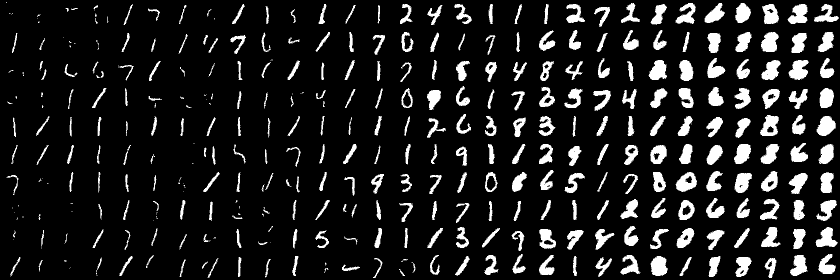

In [84]:
@torch.no_grad()
def sample_with_guidance(model, initial_noise_discrete, guidance_fn, guidance_scale,
                         num_steps=10, K=N_GRAYSCALES):
    model.eval()
    device = next(model.parameters()).device
    x_est_x0_discrete = initial_noise_discrete.clone().to(device)
    fixed_x1_sample_discrete = torch.randint(0, K, size=initial_noise_discrete.shape, device=device, dtype=torch.long)

    for i in range(num_steps):
        t_model_scalar = (num_steps - i) / num_steps
        t_for_model_nn = torch.full((x_est_x0_discrete.shape[0],), t_model_scalar, device=device, dtype=torch.float)
        mask_prob = t_model_scalar
        mask = torch.rand_like(x_est_x0_discrete, dtype=torch.float) < mask_prob
        x_t_formed_discrete = torch.where(mask, fixed_x1_sample_discrete, x_est_x0_discrete)

        logits_pred_x0 = model(x_t_formed_discrete, t_for_model_nn)

        with torch.enable_grad():
            logits_for_guidance = logits_pred_x0.clone().requires_grad_(True)
            probs_for_guidance = F.softmax(logits_for_guidance, dim=1)
            scores = guidance_fn(probs_for_guidance)
            grad_wrt_logits = torch.autograd.grad(scores, logits_for_guidance)[0]

        logits_guided = logits_pred_x0 + guidance_scale * grad_wrt_logits
        x_est_x0_discrete = torch.argmax(logits_guided, dim=1)

    return x_est_x0_discrete.squeeze(1)


def intensity_guidance_viz(model_to_guide, steps=30, num_examples=10, K_val=N_GRAYSCALES):
  device = next(model_to_guide.parameters()).device
  def intensity_objective(x):
    pixel_values_tensor = torch.arange(K_val, device=device, dtype=torch.float32).view(1, K_val, 1, 1)
    expected_img_values = torch.sum(x * pixel_values_tensor, dim=1)
    return expected_img_values.mean()
  torch.manual_seed(1)
  device_viz = next(model_to_guide.parameters()).device
  initial_noise = torch.randint(0, K_val, (num_examples, 28, 28), dtype=torch.long, device=device_viz)

  images = []
  for s in tqdm(range(steps), total=steps, unit="guidance_steps", desc="Intensity Guidance"):
    scale = torch.tensor(s / (steps - 1)) * 2 - 1
    scale *= 1e4

    sampled_imgs = sample_with_guidance(
        model_to_guide, initial_noise_discrete=initial_noise, guidance_fn=intensity_objective,
        guidance_scale=scale, num_steps=20, K=K_val)
    images.append(sampled_imgs.cpu())

  torch.random.seed()

  i = torch.stack(images, axis=0).to(torch.uint8)
  i = einops.rearrange(i, "r c w h -> (c w) (r h)")
  show_image(i)

intensity_guidance_viz(fm_model)

## Classifier Model

In [75]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 num_classes=10, base_channels=32,
                 num_groups_norm=8, use_attention_bottleneck=True,
                 K_pixel_input=N_GRAYSCALES):
        super().__init__()
        if base_channels <= 0:
            raise ValueError("base_channels must be positive.")
        self.embedding = nn.Conv2d(K_pixel_input, base_channels, kernel_size=1, padding=0)
        self.conv_in = ConvBlock(base_channels, base_channels, time_emb_dim=None, num_groups=num_groups_norm)
        self.down1 = DownBlock(base_channels, base_channels * 2, time_emb_dim=None, num_groups_norm=num_groups_norm)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim=None, num_groups_norm=num_groups_norm)
        self.bottleneck_conv1 = ConvBlock(base_channels * 4, base_channels * 8, time_emb_dim=None, num_groups=num_groups_norm)
        if use_attention_bottleneck:
            self.attention = SelfAttentionBlock(base_channels * 8, num_heads=4)
        else:
            self.attention = nn.Identity()
        bottleneck_out_channels = base_channels * 8
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier_head = nn.Linear(bottleneck_out_channels, num_classes)
        self.num_pixel_classes = K_pixel_input

    def forward(self, x):
        x = x.to(torch.long)
        x = F.one_hot(x, num_classes=self.num_pixel_classes).to(torch.float32)
        x = einops.rearrange(x, "b h w d -> b d h w")
        return self.forward_onehot(x)

    def forward_onehot(self, x):
        h = self.embedding(x)
        h = self.conv_in(h, t_emb=None)
        h = self.down1(h, t_emb=None)
        h = self.down2(h, t_emb=None)
        h = self.bottleneck_conv1(h, t_emb=None)
        h = self.attention(h)
        h = self.global_avg_pool(h)
        h = torch.flatten(h, 1)
        out_logits = self.classifier_head(h)
        return out_logits


## CE Loss

In [55]:
def ce_loss_classifier(model, batch, K_pixel_val=N_GRAYSCALES):
    x = batch[0].to(next(model.parameters()).device)
    y_digit_labels = batch[1].to(next(model.parameters()).device)
    y_logits_pred = model(x)
    loss = nn.CrossEntropyLoss()(y_logits_pred, y_digit_labels)
    predicted_classes = torch.argmax(y_logits_pred, dim=1)
    accuracy = (predicted_classes == y_digit_labels).float().mean()
    return dict(loss=loss, accuracy=accuracy)


## Train the classifier

In [76]:
classifier_model = MNISTClassifier(K_pixel_input=N_GRAYSCALES)
classifier_model.to(device)
trainer_classifier = Trainer(
    model=classifier_model, train_loader=train_loader, test_loader=test_loader,
    loss_fn=ce_loss_classifier, extra_eval_fn=None, num_epochs=1 )
trainer_classifier.train()

/Users/henning/dev/flow_matching/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch=0 test {'loss': 2.35019189119339, 'accuracy': 0.09785156254656613}


Epoch 1/1:  11%|█         | 199/1875 [00:09<01:18, 21.44 batches/s, loss=0.579, accuracy=0.781]

mean train: {'loss': 1.6542066698752078, 'accuracy': 0.3934010152284264}


Epoch 1/1:  22%|██▏       | 412/1875 [00:19<01:08, 21.49 batches/s, loss=0.118, accuracy=0.969] 

mean train: {'loss': 0.3901084248728595, 'accuracy': 0.8770539906103286}


Epoch 1/1:  33%|███▎      | 622/1875 [00:29<00:59, 21.14 batches/s, loss=0.0427, accuracy=1]    

mean train: {'loss': 0.21647653753677623, 'accuracy': 0.9382476076555024}


Epoch 1/1:  45%|████▍     | 835/1875 [00:39<00:48, 21.26 batches/s, loss=0.12, accuracy=0.969]  

mean train: {'loss': 0.1678204565383319, 'accuracy': 0.9526115023474179}


Epoch 1/1:  56%|█████▌    | 1048/1875 [00:49<00:38, 21.44 batches/s, loss=0.188, accuracy=0.938] 

mean train: {'loss': 0.15001875221152122, 'accuracy': 0.9534917840375586}


Epoch 1/1:  66%|██████▌   | 1240/1875 [00:59<00:29, 21.22 batches/s, loss=0.0123, accuracy=1]    

mean train: {'loss': 0.12167227092437953, 'accuracy': 0.963023560209424}


Epoch 1/1:  77%|███████▋  | 1446/1875 [01:10<00:20, 20.58 batches/s, loss=0.0301, accuracy=1]    

mean train: {'loss': 0.11223514819770906, 'accuracy': 0.9690533980582524}


Epoch 1/1:  88%|████████▊ | 1656/1875 [01:20<00:10, 21.37 batches/s, loss=0.0746, accuracy=0.969]

mean train: {'loss': 0.11598409482810114, 'accuracy': 0.9668154761904761}


Epoch 1/1: 100%|█████████▉| 1866/1875 [01:30<00:00, 20.94 batches/s, loss=0.0192, accuracy=1]    

mean train: {'loss': 0.10878661370611019, 'accuracy': 0.9674295774647887}


Epoch 1/1: 100%|██████████| 1875/1875 [01:30<00:00, 20.75 batches/s, loss=0.0621, accuracy=0.969]


epoch=0 test {'loss': 0.12684620963409543, 'accuracy': 0.9558593742549419}


## Classifier Guidance

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


""

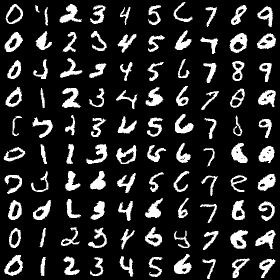

In [97]:
def class_scorer(classifier_nn, x, class_weights):
    digit_logits = classifier_nn.forward_onehot(x)
    log_probs_digits = F.log_softmax(digit_logits, dim=-1)
    score = (log_probs_digits * class_weights[None, :]).sum(dim=-1).mean()
    return score


def number_guidance(model_to_guide, classifier_model, num_examples=10, K_val=N_GRAYSCALES):
  torch.manual_seed(1)
  device_viz = next(model_to_guide.parameters()).device
  initial_noise = torch.randint(0, K_val, (num_examples, 28, 28), dtype=torch.long, device=device_viz)


  images = []
  for n in tqdm(range(10)):
    one_hot = F.one_hot(torch.tensor(n), 10).to(device)
    def scorer(x):
      return class_scorer(classifier_model, x, one_hot)
    sampled_imgs = sample_with_guidance(
      fm_model, initial_noise_discrete=initial_noise, guidance_fn=scorer,
      guidance_scale=1e4, num_steps=30, K=N_GRAYSCALES)
    images.append(sampled_imgs.cpu())
  i = torch.stack(images, axis=0).to(torch.uint8)
  i = einops.rearrange(i, "r c w h -> (c w) (r h)")
  show_image(i)


number_guidance(fm_model, classifier_model)